In [13]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn import set_config
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

set_config(transform_output='pandas')


In [22]:
class HousePriceClassifier:
    """
    Cassification pipeline for predicting whether a house is 'expensive' or 'not expensive'.
    Steps included:
        - preprocessing
        - encoding
        - model training
        - hyperparameter tuning.
    """

    def __init__(self, path):
        """
        initialize the classifier with data set
        Parameters:
        - path to csv file
        """

        self.data = pd.read_csv(path)
        self.ordinal_features = [
            'ExterQual', 'ExterCond', 'BsmtQual', 'BsmtCond', 'BsmtExposure',
            'BsmtFinType1', 'KitchenQual', 'HeatingQC', 'GarageQual',
            'GarageCond', 'PoolQC', 'Fence'
        ]

        # order is: excellent, good, typical/average, fair, poor, (nor available)
        self.order_categories = [
            ['Ex', 'Gd', 'TA', 'Fa', 'Po'],
            ['Ex', 'Gd', 'TA', 'Fa', 'Po'],
            ['Ex', 'Gd', 'TA', 'Fa', 'Po', 'NA'],
            ['Ex', 'Gd', 'TA', 'Fa', 'Po', 'NA'],
            ['Gd', 'Av', 'Mn', 'No', 'NA'],
            ['GLQ', 'ALQ', 'BLQ', 'Rec', 'LwQ', 'Unf', 'NA'],
            ['Ex', 'Gd', 'TA', 'Fa', 'Po'],
            ['Ex', 'Gd', 'TA', 'Fa', 'Po'],
            ['Ex', 'Gd', 'TA', 'Fa', 'Po', 'NA'],
            ['Ex', 'Gd', 'TA', 'Fa', 'Po', 'NA'],
            ['Ex', 'Gd', 'TA', 'Fa', 'NA'],
            ['GdPrv', 'MnPrv', 'GdWo', 'MnWw', 'NA']
        ]
        self.model = None
        self.search = None

    def prepare_data(self):
        """
        prepare training and test sets
        identify categorical and numerical columns
        """

        self.y = self.data.pop('Expensive')
        self.X = self.data.drop(columns=["Fireplaces"])
        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(
            self.X, self.y, test_size=0.2, random_state=42
        )
        self.X_num = self.X_train.select_dtypes(include='number').columns
        self.X_cat = self.X_train.select_dtypes(exclude='number').columns

        self.oh_features = [col for col in self.X_cat if col not in self.ordinal_features]

    def build_preprocessor(self):
        """
        constructs the preprocessing pipeline for numerical and categorical data
        """

        # impute missing values with mean for numerical features and 'NA' for categorical features
        num_imputer = SimpleImputer(strategy='mean')
        cat_imputer = SimpleImputer(strategy='constant', fill_value='NA')

        # encode categorical data with ordinal encoder for features that have a 'logical' order
        # encode categorical data with one hot encoder for features with no order
        oh_encoder = OneHotEncoder(handle_unknown='infrequent_if_exist', sparse_output=False)
        ord_encoder = OrdinalEncoder(categories=self.order_categories)

        cat_encoder = ColumnTransformer(transformers=[
            ('oh', oh_encoder, self.oh_features),
            ('ord', ord_encoder, self.ordinal_features)
        ], verbose_feature_names_out=False)

        # full pipelines including both imputers and encoders
        self.num_pipeline = Pipeline([('imputer', num_imputer)])
        self.cat_pipeline = Pipeline([
            ('imputer', cat_imputer),
            ('encoder', cat_encoder)
        ])

        # final preprocessor
        self.preprocessor = ColumnTransformer(transformers=[
            ('num', self.num_pipeline, self.X_num),
            ('cat', self.cat_pipeline, self.X_cat)
        ], verbose_feature_names_out=False)

    def build_model(self):
        """
        build a complete RandomForest pipeline including preprocessing
        """
        self.model = Pipeline([
            ("preprocessor", self.preprocessor),
            ("classifier", RandomForestClassifier())

        ])

    def tune_model(self, n_iter=300, cv=5):
        """
        performs randomized hyperparameter search on the model
        """
        # ranges were found and refined after several tuning iterations
        param_grid = {
            'classifier__n_estimators': range(168, 175),
            'classifier__ccp_alpha': [10**e for e in range(-6, -4)],
            'classifier__max_depth': range(10, 14),
            'classifier__min_samples_split': range(2, 21, 2),
            'classifier__min_samples_leaf': range(1, 11)
        }

        self.search = RandomizedSearchCV(
            self.model,
            param_distributions=param_grid,
            n_iter=n_iter,
            cv=cv,
            verbose=1,
            n_jobs=-1,
            random_state=42
        )

        self.search.fit(self.X_train, self.y_train) # hier soll ein output kommen (die pipeline)

        print(self.search.best_params_)
        print(self.search.best_score_)

    def evaluate(self):
        """
        evaluates the tuned model on the test set and displays a confusion matrix
        """
        best_model = self.search.best_estimator_
        y_pred = best_model.predict(self.X_test)
        acc = accuracy_score(self.y_test, y_pred)
        print("Accuracy score:", acc)

        # Confusion Matrix
        labels = ["unexpensive", "expensive"]
        cm = confusion_matrix(self.y_test, y_pred)
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
        disp.plot(cmap='Blues')
        plt.title("Confusion Matrix")
        plt.grid(False)
        plt.show()


        return acc


In [23]:
classifier = HousePriceClassifier("housing_iteration_5_classification.csv")
classifier.prepare_data()
classifier.build_preprocessor()
classifier.build_model()


Fitting 5 folds for each of 300 candidates, totalling 1500 fits
{'classifier__n_estimators': 169, 'classifier__min_samples_split': 2, 'classifier__min_samples_leaf': 1, 'classifier__max_depth': 11, 'classifier__ccp_alpha': 1e-05}
0.9503429808150837
Accuracy score: 0.9486301369863014


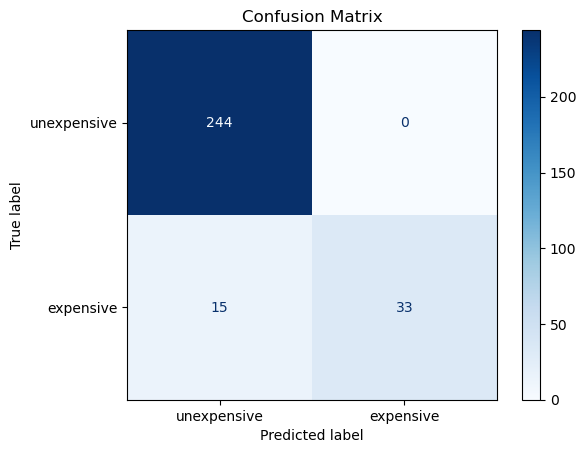

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer())]),
                                                  Index(['LotArea', 'LotFrontage', 'TotalBsmtSF', 'BedroomAbvGr', 'PoolArea',
       'GarageCars', 'WoodDeckSF', 'ScreenPorch', 'MSSubClass', 'OverallQual',
       'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1',
       'BsmtFinSF2', 'BsmtUnfSF', '1s...
       'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'BsmtFinType2',
       'HeatingQC', 'Electrical', 'Functional', 'GarageType', 'GarageFinish',
       'GarageQual', 'GarageCond', 'PavedDrive', 'PoolQC', 'Fence',
       'MiscFeature', 'SaleType', 'SaleCondition'],
      dtype='object'))],
                                   verbose_feature_names_out=False)),
                ('classifier',
                 RandomForestClassifier(ccp_alpha=1e-05, max_depth=11,
                                        n_estimators=169))])

In [24]:
from sklearn import set_config
set_config(display='diagram')  

classifier.model  # show a visual representation of the pipeline

classifier.tune_model()
classifier.evaluate()

classifier.search.best_estimator_